In [2]:
#Importing the librairies

import numpy as np
import matplotlib.pyplot as plt
import random
try:
    import importlib
    importlib.reload(h)
    importlib.reload(f)
    importlib.reload(d)
except NameError: # It hasn't been imported yet
    import helpers as h
    import implementations as f
    import data_processing as d

# Data preprocessing and feature selections

## Data preprocessing

To open the data, the data folder needs to be one level above the project folder and the data-dontaining folder needs to be named 'data'. The data folder should contain the following files:
- 'x_train.csv'
- 'y_train.csv'
- 'x_test.csv'

#For this to work, the data folder needs to be one level above the project folder and the folder name needs
#to be 'data'
data_folder = '../data/'
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data(data_folder)


In [3]:
np.random.seed(0)

In [3]:
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data("../data")

In [ ]:
#Saving the generated arrays in .npy files in order to have faster access to them

np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [4]:
#Loading the arrays from the .npy files

x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [5]:
#Generates the features names

features_name = np.genfromtxt('../data/x_train.csv', delimiter=',', dtype=str, max_rows=1)[1:] 

## Features selection

The original data contains 321 features, but the majority of them are not useful for the prediction. Therefore, we need to select the features that are useful for the prediction. The American Heart Association (AHA) identifies a range of risk factors for heart disease, including:
- Tobacco and alcohol use
- Physical inactivity
- Nutrution
- Obesity & overweight
- Blood cholesterol
- Diabetes
- Blood pressure

and some factors having an influence on the risk factors as : 
- Age
- Income 
- Education
- Gender
- Access and affordability of health care

To represent these factors, the following 21 features were selected:

- GENHLTH: General health condition
- MENTHLTH: Number of days with mental health not good
- PHYSHLTH: Number of days with physical health not good
- HLTHPLN1 : Health care coverage
- MEDCOST : Delayed medical treatment due to costs
- TOLDHI2 : High blood cholesterol
- CVDSTRK3 : Ever told you had a stroke
- DIABETE3 : Ever told you had diabetes
- SEX : Gender of the respondent
- EDUCA : Level of education
- INCOME2 : Annual household income
- DIFFWALK : Difficulty walking
- SMOKE100 : Smoked at least 100 cigarettes in life
- _RFHYPE5 : High blood pressure
- _CHOLCHK : Checked cholesterol within the last 5 years
- _AGEG5YR : Age group
- _BMI5 : Body mass index
- _TOTINDA : Physical activity
- _FRTLT1 : Fruit consumption
- _VEGLT1 : Vegetable consumption
- _RFDRHV5 : Heavy drinking



In [6]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2', ]


In [7]:
#Create a mask for feature selection and apply it to the data

trainMask, testMask = f.masking((x_train, x_test), features_name, features_list)


## Processing [Necessary] 
### We want to clean the data for each feature, making them binary for yes/no, etc... and rename them

In [8]:
#Train and test feature cleaning and processing

trainProcessed = d.feature_processing_test(trainMask)
testProcessed  = d.feature_processing_test(testMask)

#Replace missing values by the mean of the feature

x_train_algo = f.replaceMissingValuesMean(trainMask)
x_test_algo = f.replaceMissingValuesMean(testMask)

## Balancing the data

One of the main problem of the dataset is that the proportion of persons with heart diseases and persons without heart diseases is not balanced. Indeed, only around 9% have a heart disease. Therefore, to avoid the model to be biased, we need to balance the data. We will try several split of the data to see which one gives the best results.

| Split                | Sample size with heart diseases | Sample size without heart diseases | Total sample size                  |
|----------------------|---------------------------------|------------------------------------| ---------------------------------- |
| Initial split: 10-90 | 28975                           | 299160                             | 328135                             |
| 50-50                | 28975                           | 28975                              | 57950                              |
| 30-70                | 28975                           | 67608                              | 96583                              |

In [9]:
#Separate de data into the two classes

heart_dis = x_train_algo[y_train == 1]
non_hd = x_train_algo[y_train == -1]


#Generate a random sample of the same size as the heart disease class (or of the size of the wanted split)
random_indices_nonhd = np.random.choice(range(len(non_hd)), len(heart_dis), replace=False)

#Concatenate the two classes
train_sample = np.concatenate((heart_dis, non_hd[random_indices_nonhd]), axis=0)


In [10]:
#Create the corresponding labels

y_train_sample = np.concatenate((np.ones(len(heart_dis)), -np.ones(len(heart_dis))), axis=0)

#shuffle both train_sample and y_train_sample the same way

shuffle_indices = np.random.permutation(len(train_sample))
train_sample = train_sample[shuffle_indices]
y_train_sample = y_train_sample[shuffle_indices]

#Check the shape of the data

print(train_sample.shape, y_train_sample.shape)

(57950, 21) (57950,)


a delete?

In [19]:

#X = [x_train, x_test]
#print(x_train.shape)

#for i,x in enumerate(X): 
#    x = d.masking(x, features_name,features_list)
#    x = d.feature_processing_test(x)
#    x = d.replace_nan_mean_column(x)
#    X[i] = x


#x_train_algo, x_test_algo = X[0], X[1]

(328135, 321)


In [9]:
##test chelou
#x1_stand=f.standardize(x_train_algo)
x_train_stand=np.ones(x_train_algo.shape)
x_test_stand=np.ones(x_test_algo.shape)

x_trai_stand=f.standardize(x_train_algo)

for i in range(len(features_list)):
  x_train_stand[i]=f.standardize(x_train_algo[i])
  x_test_stand[i]=f.standardize(x_test_algo[i])

print(x_trai_stand==x_train_stand)



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


## Model Training :

Now that we have our data, we can train our model. We will use the following models:

- Gradient descent with mean squared error
- Stochoastic gradient descent with mean squared error
- Least squares regression
- Ridge regression
- Logistic regression
- Regularized logistic regression

In [11]:
#Add a column of ones to the data to take into account the bias

tX_train = np.c_[np.ones((len(train_sample), 1)), train_sample]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_algo]

### Initialisation of set parameters

In [12]:
#Random initialization of the weights

initial_w = [random.choice([1, -1]) for i in range(len(tX_train[0]))]
max_iter = 500

### Separation of the dataset in a test/train set

In [13]:
#tX_train_train = tX_train[:int(len(tX_train)*0.7)]
#y_train_train = y_train_sample[:int(len(tX_train)*0.7)]
#tX_train_validation = tX_train[int(len(tX_train)*0.7):]
#y_train_validation = y_train_sample[int(len(tX_train)*0.7):]

split=int((len(tX_train))*0.6)
tX_train_train, tX_train_validation = np.split(tX_train,[split])
y_train_train, y_train_validation = np.split(y_train_sample,[split])


## And then, we can run the algorithms

1. MSE gradient descent

In [15]:
tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]

tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)),:]
y_train_neg_red = y_train_neg[:int(len(tX_train_pos))]

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

We try several weights for gamma to see which one is the best

In [16]:
#Compute gradient descent with MSE as loss function (see functions.py for the function)
w_mse_gd_gamma1, loss_mse_gd_gamma1 = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 2000, 0.0078)
w_mse_gd_gamma2, loss_mse_gd_gamma2 = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 2000, 0.007)
w_mse_gd_gamma3, loss_mse_gd_gamma3 = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 15000, 0.00001)


Gradient Descent(1999/2000): Final loss=2.737191447418523e+67
Gradient Descent(1999/2000): Final loss=0.3582481495896749
Gradient Descent(14999/15000): Final loss=2.6670542490534266


In [17]:
loss_test_set_1 = []
for w in w_mse_gd_gamma1:
    loss_test_set_1.append(f.compute_mse(y_train_validation, tX_train_validation, w))

final_loss_test_1 = loss_test_set_1[len(loss_test_set_1)-1]

loss_test_set_2 = []
for w in w_mse_gd_gamma2:
    loss_test_set_2.append(f.compute_mse(y_train_validation, tX_train_validation, w))
final_loss_test_2 = loss_test_set_2[len(loss_test_set_2)-1]

loss_test_set_3 = []
for w in w_mse_gd_gamma3:
    loss_test_set_3.append(f.compute_mse(y_train_validation, tX_train_validation, w))
final_loss_test_3 = loss_test_set_3[len(loss_test_set_3)-1]

print(final_loss_test_1,final_loss_test_2, final_loss_test_3)


2.7616644779102535e+67 0.3524667595618095 2.667292298450259


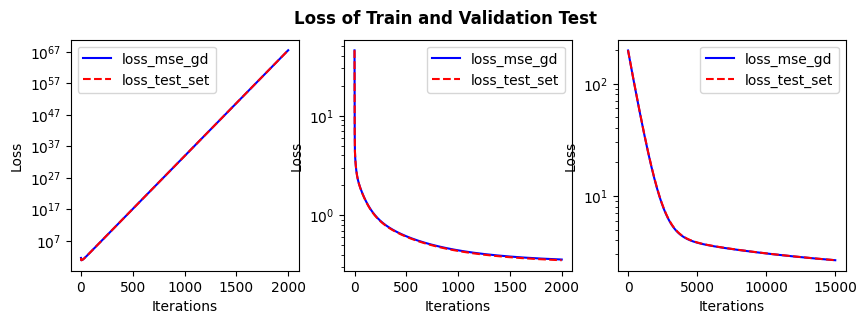

In [19]:
loss_mse_gd = [loss_mse_gd_gamma1,loss_mse_gd_gamma2,loss_mse_gd_gamma3]
loss_test_set = [loss_test_set_1,loss_test_set_2,loss_test_set_3]

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plotting the loss for training and test set on each subplot
for i in range(3):
    axs[i].semilogy(loss_mse_gd[i], '-b', label='loss_mse_gd')
    axs[i].semilogy(loss_test_set[i], '--r', label='loss_test_set')
    axs[i].legend(frameon=True)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Loss')

# Adding a title to the entire figure
fig.suptitle('Loss of Train and Validation Test', fontweight='bold')

plt.show()

???? We compare the progression of the loss on the test set, in order to ensure there's no overfitting with the increasing amount of iteration

In [20]:
y_pred = tX_train_validation.dot(w_mse_gd_gamma2[-1, :])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))
print("F1 score: ", f1)


Accuracy:  0.7506471095772217
F1 score:  0.7548354258568035


In [60]:
h.create_csv_submission(test_ids, y_pred, 'submission_gd_8.csv')

In [21]:
#Test the model on the test sample. Do we need to standardize ?

y_test = tX_test.dot(w_mse_gd_gamma2[-1, :])
y_test_rounded = np.where(y_test > 0, 1, -1) 

print('weights = \n\n', w_mse_gd_gamma2[-1, :],'\n\n Loss = ', loss_mse_gd_gamma2[-1],'\n\n*****************************************************************************',
      ' \n\n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded == 1)/len(y_test_rounded))

weights = 

 [-1.20758112  0.17012164  0.00219882  0.00369828  0.44114273  0.27542303
 -0.20433979 -0.67270829 -0.06149823 -0.15232781  0.0332414  -0.00271063
  0.04165451 -0.23821612 -0.23823572 -0.24198414  0.08526177  0.9555938
  0.52950723 -0.1383473   0.16562815  0.08120112] 

 Loss =  0.3582481495896749 

*****************************************************************************  

 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.30902641274833376


Lets run some cross validation to see the best initial weights (as a function of the proportion of 1, -1 and 0)


2. MSE SGD

SGD iter. 999/999: loss=4.150066463225863, w0=-1.13583065077735, w1=-1.0981326705987504
0.000100: 4.150066


NameError: name 'y' is not defined

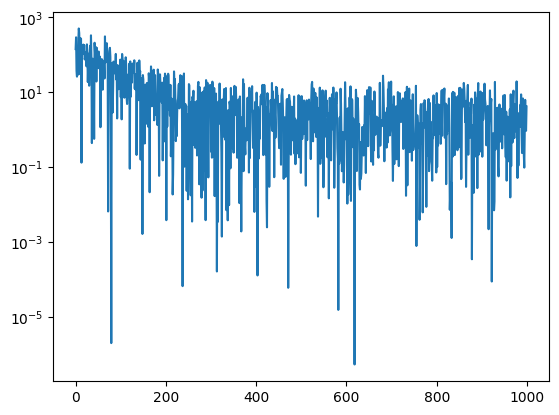

In [22]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(0.0001, 0.0015, 0.0001)
g_opti = gamma[0]
loss_opti = 1000
plotLossMSE
for g in gamma:
    weights, loss = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 1000, g)
    mean_loss = np.mean(loss[-100:])
    if mean_loss < loss_opti:
        loss_opti = mean_loss
        g_opti = g
    print("%f: %f" % (g, loss[-1]))
    plt.semilogy(loss, label = "%f" % g)

    for w in weights:
        loss_test_set.append(f.compute_mse(y, x, w))

    plt.figure(0)
    plt.semilogy(loss)
    plt.semilogy(loss_test_set)
    plt.ylabel("loss")
    plt.xlabel("iterations")
    plt.title("??",fontweight='bold')
    plt.show()


In [23]:
w_mse_sgd, loss_mse_sgd = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 8000, 0.001)

SGD iter. 7999/7999: loss=0.047227426115033604, w0=-1.2284610318485878, w1=0.19470854752627859


In [26]:
y_pred = tX_train_validation.dot(w_mse_sgd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.62053494391717
F1 score:  0.4824664626971052


In [27]:
y_test_sgd = tX_test.dot(w_mse_sgd[-1])
y_test_rounded_sgd = np.where(y_test_sgd > 0, 1, -1)

print('weights = \n', w_mse_sgd[-1],'\n Loss = ', loss_mse_sgd[-1],'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded_sgd == 1)/len(y_test_rounded_sgd))

weights = 
 [-1.22846103  0.19470855  0.00732497 -0.02021434  0.61107287  0.42228268
 -0.04913965 -0.87315923 -0.07536617 -0.01618828  0.04576833  0.010893
  0.14689832 -0.44034975 -0.16638435 -0.49026035  0.03119532  0.95763813
  0.58952006 -0.30548519  0.37909534  0.18786255] 
 Loss =  0.047227426115033604 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.13155176039276278


3. Least squares

In [28]:
w_ls, loss_ls = f.least_squares(y_train_train, tX_train_train)

In [29]:
#split the train data with 50/50 label
tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]
print(len(tX_train_neg), len(tX_train_pos))

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]

tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*2),:]
y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*2)]

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))


17468 17302


In [30]:
w_ls, loss_ls = f.least_squares(y_train_train_reduced, tX_train_train_reduced)

In [32]:
y_pred = tX_train_validation.dot(w_ls)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.7723037100949094
F1 score:  0.7806864456079116


In [33]:

y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0, 1, -1)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ls == 1)/len(y_test_ls))

weights = 
 [-0.16502062  0.15774841  0.00042782  0.00203913 -0.08154495 -0.0719034
 -0.24012925 -0.32889172 -0.06464679 -0.24972556 -0.00687264 -0.01756
 -0.14605043 -0.11874807 -0.24733902  0.17421612  0.07001045 -0.1731449
  0.07302285 -0.00816099 -0.01574986  0.00961871] 
 Loss =  0.32361312699948286 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.30693277502994176


In [34]:
h.create_csv_submission(test_ids, y_test_ls, 'submission_ls_8.csv')

4. Ridge regression

In [35]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(5*10**(-7), 1*10**(-6), 1*10**(-7))
#gamma = [44,12,3, 0.1, 5*10**(-7)]
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w_ridge, loss_ridge = f.ridge_regression(y_train_train, tX_train_train, g)
    if loss_ridge < loss_opti:
        loss_opti = loss_ridge
        g_opti = g
    print("%e: %f" % (g, loss_ridge))
    #plt.semilogy(loss_ridge, label = "%f" % g)

print("optimal gamma: %.e " % g_opti)
#plt.legend()
#plt.show()


5.000000e-07: 0.323613
6.000000e-07: 0.323613
7.000000e-07: 0.323613
8.000000e-07: 0.323613
9.000000e-07: 0.323613
optimal gamma: 5e-07 


In [36]:
w_ridge, loss_ridge = f.ridge_regression(y_train_train_reduced, tX_train_train_reduced, 5*10**(-7))

In [38]:
y_pred = tX_train_validation.dot(w_ridge)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.7723037100949094
F1 score:  0.7806864456079116


In [39]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0, 1, -1)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ridge == 1)/len(y_test_ridge))

weights = 
 [-0.16501591  0.15774744  0.00042785  0.00203911 -0.08154525 -0.07190374
 -0.24012876 -0.32889016 -0.0646471  -0.24972484 -0.00687336 -0.01756021
 -0.14605035 -0.11874809 -0.24733826  0.17421237  0.07001058 -0.17311009
  0.07301652 -0.00816157 -0.01575     0.00961798] 
 Loss =  0.3236131270039792 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.30693277502994176


In [98]:
h.create_csv_submission(test_ids, y_test_ridge, 'submission_ridge.csv')

5. Logistic regression

In [40]:
tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]

tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*2),:]
y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*2)]

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

In [45]:
y_train_processed_logreg = np.where(y_train == 1, 1, 0)
y_train_train_lg = np.where(y_train_train_reduced == 1, 1, 0)
y_train_test_lg = np.where(y_train_validation == 1, 1, 0)
initial_w = [random.choice([1, 0]) for i in range(len(tX_train[0]))]
#transform initial_w as an array
initial_w = np.array(initial_w)

Gradient Descent(99/99): loss=0.9429739615968524, w0=0.6530139208198062, w1=0.10561030311349939
1.000000e-01: 0.942974
Gradient Descent(99/99): loss=2.0060955023068656, w0=0.6802406155495713, w1=0.2526875492152493
1.100000e-01: 2.006096
Gradient Descent(99/99): loss=2.3139930517266696, w0=0.674304408068123, w1=0.3072303092517489
1.200000e-01: 2.313993
Gradient Descent(99/99): loss=0.9555704427685523, w0=0.6439266597225894, w1=0.28714892144813714
1.300000e-01: 0.955570
Gradient Descent(99/99): loss=0.9613257701230974, w0=0.6319350463944081, w1=0.32738894627157034
1.400000e-01: 0.961326
Gradient Descent(99/99): loss=1.1384404858204218, w0=0.5909834064782953, w1=0.30033642433865354
1.500000e-01: 1.138440
Gradient Descent(99/99): loss=1.6108078708217608, w0=0.5856836086117148, w1=0.32418866996621276
1.600000e-01: 1.610808
Gradient Descent(99/99): loss=1.7007454110661526, w0=0.5736348508802219, w1=0.3585993787898465
1.700000e-01: 1.700745
Gradient Descent(99/99): loss=1.7897046287235527, w0

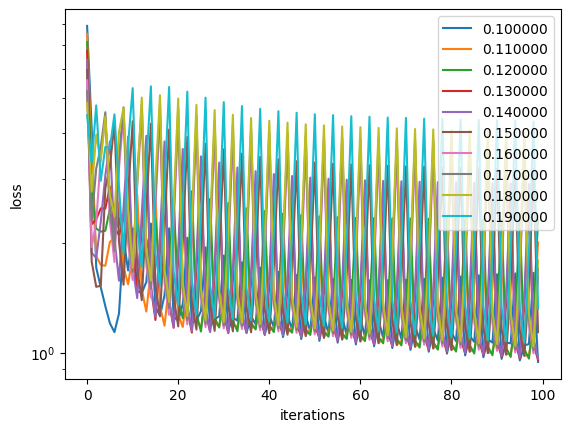

In [46]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(10*10**(-2), 20*10**(-2), 1*10**(-2))
#gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train_train_reduced, initial_w, 100, g)
    if np.mean(loss_logreg[-10:]) < loss_opti:
        loss_opti = np.mean(loss_logreg[-10:])
        g_opti = g
    print("%e: %f" % (g, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%f" % g)

print("optimal gamma: %e " % g_opti)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

In [47]:
w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train_train_reduced,initial_w, 1000, 0.1)

Gradient Descent(999/999): loss=0.7371139882301361, w0=0.219818154115639, w1=0.6457292873935575


In [48]:
def plotLossLOGREG(weights, loss, y, x ):
    loss_test_set = []

    for w in weights:
        loss_test_set.append(f.compute_loss_logistic(y, x, w))

    plt.figure(0)
    plt.semilogy(loss, label = "initial_loss")
    plt.semilogy(loss_test_set, label = "test_loss")
    plt.legend()
    plt.show()

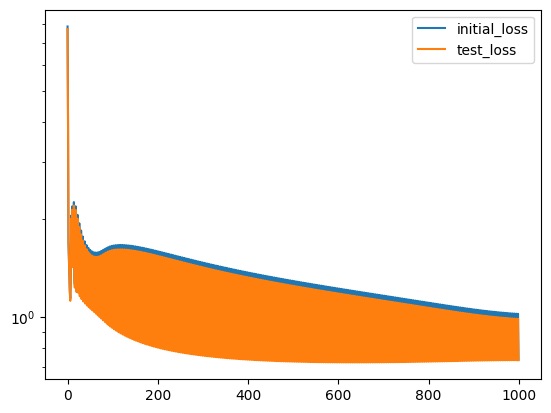

In [50]:
plotLossLOGREG(w_logreg, loss_logreg, y_train_test_lg, tX_train_validation)

In [53]:
y_pred = tX_train_validation.dot(w_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.6363675582398619
F1 score:  0.47063995478239024


In [54]:
y_test_logreg = tX_test.dot(w_logreg[-1, :])
y_test_logreg = np.where(y_test_logreg > 0.5, 1, 0)

print('weights = \n', w_logreg[-1,:],'\n Loss = ', loss_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_logreg == 1)/len(y_test_logreg))

weights = 
 [ 0.21981815  0.64572929 -0.01496847 -0.01797288  0.32288373  0.03786498
 -1.12696349 -1.49554605 -0.43008641 -1.37056459 -0.18513781 -0.14927066
 -0.9539116  -0.54000592 -1.15228463  0.27404445  0.27408206  0.76190574
 -0.46933982 -0.05288289  0.04138281 -0.1278464 ] 
 Loss =  0.7371139882301361 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.07094597683284726


In [55]:
y_sub = np.where(y_test_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_logreg.csv')

6. Regularized logistic regression

In [56]:
#Try different values of gamma for gradient descent with MSE as loss function
#gamma = np.arange(10*10**(-2), 20*10**(-2), 1*10**(-2))
gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1]
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
g_opti = gamma[0]
l_opti = lambdas[0]
loss_opti = 1000
for l in lambdas:
    for g in gamma:
        w_logreg, loss_logreg = f.reg_logistic_regression(y_train_train_lg, tX_train_train_reduced,l,  initial_w, 1000, g)
        if np.mean(loss_logreg[-10:]) < loss_opti:
            loss_opti = np.mean(loss_logreg[-10:])
            g_opti = g
            l_opti = l
        #print("%e, %e: %f" % (g, l, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%.5f, %.5f" % (g, l) )

print("optimal gamma: %e " % g_opti)
print("optimal lambda: %e " % l_opti)
plt.legend()
plt.show()

In [217]:
w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_train_lg, tX_train_train_reduced, l_opti, initial_w, 6000, g_opti)

In [218]:
y_pred = tX_train_test.dot(w_reg_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.8695658798969936
F1 score:  0.37012509197939664


In [219]:
y_test_reg_logreg = tX_test.dot(w_reg_logreg[-1])
y_test_reg_logreg = np.where(y_test_reg_logreg > 0.5, 1, 0)

print('weights = \n', w_reg_logreg[-1],'\n Loss = ', loss_reg_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_reg_logreg == 1)/len(y_test_reg_logreg))


weights = 
 [-0.08528558  0.21019329  0.01909041  0.00178655 -0.04090119 -0.08167134
 -0.26771923 -0.21615422 -0.24112636 -0.2626394  -0.16627398 -0.10377971
 -0.16877567 -0.17122445 -0.27945675  0.03567885  0.18228154 -0.01988684
 -0.06387902 -0.01686432 -0.01034752 -0.01689669] 
 Loss =  0.501688356246266 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.11644831274741953


In [38]:
y_sub = np.where(y_test_reg_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_reg_logreg7.csv')